In [1]:
import os

import openslide
import shapely
import skimage.exposure
import sklearn.cluster

from tqdm import tqdm
from math import ceil
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import tables

import geojson
from shapely.geometry import shape
from shapely.strtree import STRtree
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

import torch
from torch import nn
import numpy as np
import cv2
import gzip

from scipy import stats, signal, ndimage
from skimage import feature, morphology, measure
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.segmentation import felzenszwalb, watershed
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.filters import rank
from skimage import color
from scipy import ndimage as ndi
from PIL import Image


In [2]:

def qupath_color_to_rgb(n):
    if n < 0:
        n = (1 << 24) + n

    red = (n >> 16) & 0xFF
    green = (n >> 8) & 0xFF
    blue = n & 0xFF

    return red, green, blue


## function to convert RGB to qupath color
def rgb_to_qupath_color(red, green, blue, alpha=255):
    unsigned_int = (alpha << 24) | (red << 16) | (green << 8) | blue
    signed_int = unsigned_int if unsigned_int < 0x80000000 else unsigned_int - 0x100000000
    return signed_int

## Split the array into batches of size n
def divide_batch(l, n):
    for i in range(0, l.shape[0], n):
        yield l[i:i + n,::]


# set size of the tile and level (here corresponds to 40/8 = 5x magnification)
tile_size = 1024
openslidelevel = 3



Processing image: 10
Polygon geojson: D:\Molar_Pregnancy\Aron_to_share\Annotations\DP00002010.json.gz
WSI: D:\Molar_Pregnancy\molar_data\tif_slides\DP00002010.tif
done loading polygons
done creating trees


✅ Done looping through all images and tiles.
Total number of tiles: 104


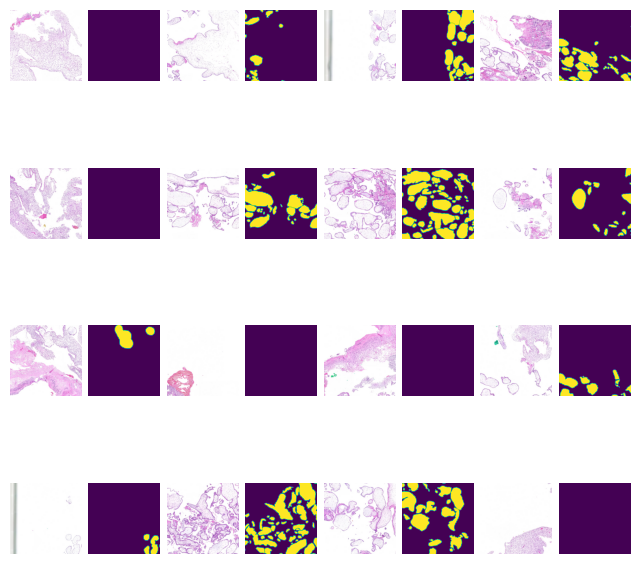

✅ Done constructing datasets
Total number of training tiles: 83, test tiles: 21


In [3]:
image_numbers = [10]  # Add more if needed
# image_numbers = [6, 9, 1, 10]  # Add more if needed

all_tiles = []
all_masks = []

for img_num in image_numbers:
    print(f"\nProcessing image: {img_num}")
    json_fname_polygons = f'D:\\Molar_Pregnancy\\Aron_to_share\\Annotations\\DP000020{str(img_num).zfill(2)}.json.gz'
    wsi_fname = f'D:\\Molar_Pregnancy\\molar_data\\tif_slides\\DP000020{str(img_num).zfill(2)}.tif'

    print(f'Polygon geojson: {json_fname_polygons}')
    print(f'WSI: {wsi_fname}')

    # read geojson
    if json_fname_polygons.endswith(".gz"):
        with gzip.GzipFile(json_fname_polygons, 'r') as f:
            allobjects = geojson.loads(f.read())
    else:
        with open(json_fname_polygons) as f:
            allobjects = geojson.load(f)
    print("done loading polygons")

    allpolygons = [shape(obj["geometry"]) for obj in allobjects]

    # fix multipolygons
    allpolygons_ = []
    for poly in allpolygons:
        if isinstance(poly, shapely.MultiPolygon):
            areas = [subpoly.area for subpoly in poly.geoms]
            allpolygons_.append(poly.geoms[np.argmax(areas)])
        else:
            allpolygons_.append(poly)
    allpolygons = allpolygons_

    # create trees
    searchtree_shapes = STRtree(allpolygons)
    searchtree_centers = STRtree([poly.centroid for poly in allpolygons])
    print("done creating trees")

    osh = openslide.OpenSlide(wsi_fname)
    scalefactor = int(osh.level_downsamples[openslidelevel])
    convert_coords_to_int = lambda x: np.array(x).round().astype(np.int32)

    for y in tqdm(range(0, osh.level_dimensions[0][1], round(tile_size * scalefactor)), desc=f"outer {img_num}", leave=False):
        for x in range(0, osh.level_dimensions[0][0], round(tile_size * scalefactor)):

            tilepoly = Polygon([
                [x, y], [x + tile_size * scalefactor, y],
                [x + tile_size * scalefactor, y + tile_size * scalefactor],
                [x, y + tile_size * scalefactor]
            ])

            hits = searchtree_shapes.query(tilepoly, predicate='intersects')
            tile = np.array(osh.read_region((x, y), openslidelevel, (tile_size, tile_size)))[:, :, :3]
            multi_mask = np.zeros((tile_size, tile_size), dtype=np.uint8)

            # fix padding
            if x + tile_size * scalefactor >= osh.level_dimensions[0][0]:
                valid_x = int((osh.level_dimensions[0][0]-1-x)//scalefactor)
                tile[:, valid_x:, :] = 255
            if y + tile_size * scalefactor >= osh.level_dimensions[0][1]:
                valid_y = int((osh.level_dimensions[0][1]-1-y)//scalefactor)
                tile[valid_y:, :, :] = 255

            if np.mean(cv2.cvtColor(tile, cv2.COLOR_RGB2GRAY)) > 250:
                continue

            for hit in hits:
                poly = searchtree_shapes.geometries.take(hit)
                poly_internal = shapely.buffer(poly, distance=-20) # modified from -50 to -10 for better internal region extraction

                coords_ext = np.array(poly.exterior.coords.xy).T
                cv2.fillPoly(multi_mask, pts=convert_coords_to_int([(coords_ext - np.array([x, y])) / scalefactor]), color=1)

                if isinstance(poly_internal, shapely.Polygon):
                    coords_int = np.array(poly_internal.exterior.coords.xy).T
                    cv2.fillPoly(multi_mask, pts=convert_coords_to_int([(coords_int - np.array([x, y])) / scalefactor]), color=2)
                else:
                    for sub_poly in poly_internal.geoms:
                        coords_int = np.array(sub_poly.exterior.coords.xy).T
                        cv2.fillPoly(multi_mask, pts=convert_coords_to_int([(coords_int - np.array([x, y])) / scalefactor]), color=2)

            all_tiles.append(tile)
            all_masks.append(multi_mask)

print("✅ Done looping through all images and tiles.")
print(f'Total number of tiles: {len(all_tiles)}')

# Random subset (optional)
np.random.seed(42)
selected_samples = np.random.choice(a=len(all_tiles), size=min(1000, len(all_tiles)), replace=False)
all_tiles = [all_tiles[i] for i in selected_samples]
all_masks = [all_masks[i] for i in selected_samples]

# Visualize
fig, axes = plt.subplots(4, 4*2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(4):
    for j in range(4):
        axes[i, 2*j].imshow(all_tiles[4*i+j])
        axes[i, 2*j].axis('off')
        axes[i, 2*j+1].imshow(all_masks[4*i+j])
        axes[i, 2*j+1].axis('off')
plt.show()

# Train-test split
tiles_train, tiles_test, masks_train, masks_test = sklearn.model_selection.train_test_split(all_tiles, all_masks, train_size=0.8, random_state=42)

# Save to pytable
filters = tables.Filters(complevel=6, complib='zlib')
hdf5_train = tables.open_file(f'D:\\Molar_Pregnancy\\Aron_to_share\\Datasets\\data_villi_multi_train.pytable', mode='w', filters=filters)
hdf5_test = tables.open_file(f'D:\\Molar_Pregnancy\\Aron_to_share\\Datasets\\data_villi_multi_test.pytable', mode='w', filters=filters)

def initialize_storage(hdf5_file, num_samples):
    storage = {}
    block_shape = {
        "img": np.array((tile_size, tile_size, 3)),
        "mask": np.array((tile_size, tile_size)),
        "label": np.array((tile_size, tile_size)),
    }
    imgtypes = ["img", "mask", "label"]
    img_dtype = {
        "img": tables.UInt8Atom(),
        "mask": tables.UInt8Atom(),
        "label": tables.Int16Atom(),
    }

    for imgtype in imgtypes:
        storage[imgtype] = hdf5_file.create_earray(
            hdf5_file.root, imgtype, img_dtype[imgtype],
            shape=(0,) + tuple(block_shape[imgtype]),
            chunkshape=(1,) + tuple(block_shape[imgtype])
        )
    return storage

storage_train = initialize_storage(hdf5_train, len(tiles_train))
storage_test = initialize_storage(hdf5_test, len(tiles_test))

classes = [0, 1, 2]
totals_train = np.zeros((2, len(classes)), dtype=np.int32)
totals_test = np.zeros((2, len(classes)), dtype=np.int32)

for tile, mask in zip(tiles_train, masks_train):
    storage_train["img"].append(tile[np.newaxis])
    storage_train["mask"].append(mask[np.newaxis])
    for i, key in enumerate(classes):
        totals_train[1, i] += np.sum(mask == key)

for tile, mask in zip(tiles_test, masks_test):
    storage_test["img"].append(tile[np.newaxis])
    storage_test["mask"].append(mask[np.newaxis])
    for i, key in enumerate(classes):
        totals_test[1, i] += np.sum(mask == key)

hdf5_train.create_carray(hdf5_train.root, 'numpixels', tables.Atom.from_dtype(totals_train.dtype), totals_train.shape)[:] = totals_train
hdf5_test.create_carray(hdf5_test.root, 'numpixels', tables.Atom.from_dtype(totals_test.dtype), totals_test.shape)[:] = totals_test

hdf5_train.close()
hdf5_test.close()

print('✅ Done constructing datasets')
print(f'Total number of training tiles: {len(tiles_train)}, test tiles: {len(tiles_test)}')